In [2]:
# Upload data and viewing

# 1️⃣ Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# 2️⃣ Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

# 3️⃣ Display Basic Info
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Submission Shape:", submission.shape)

# 4️⃣ Display First Rows
train.head()


Train Shape: (230130, 6)
Test Shape: (98550, 5)
Submission Shape: (98550, 2)


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
# Exploratory Data Analysis (EDA)

# 1️⃣ Check for Missing Values
print("Missing values in train:\n", train.isnull().sum())

# 2️⃣ Data Types and Basic Info
train.info()

# 3️⃣ Date Range
train["date"] = pd.to_datetime(train["date"])
print("Date range in train:", train["date"].min(), "to", train["date"].max())

# 4️⃣ Unique Values Per Column
for col in ["country", "store", "product"]:
    print(f"{col}: {train[col].nunique()} unique values")

# 5️⃣ Basic Statistics of num_sold
train["num_sold"].describe()


Missing values in train:
 id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
Date range in train: 2010-01-01 00:00:00 to 2016-12-31 00:00:00
country: 6 unique values
store: 3 unique values
product: 5 unique values


count    221259.000000
mean        752.527382
std         690.165445
min           5.000000
25%         219.000000
50%         605.000000
75%        1114.000000
max        5939.000000
Name: num_sold, dtype: float64

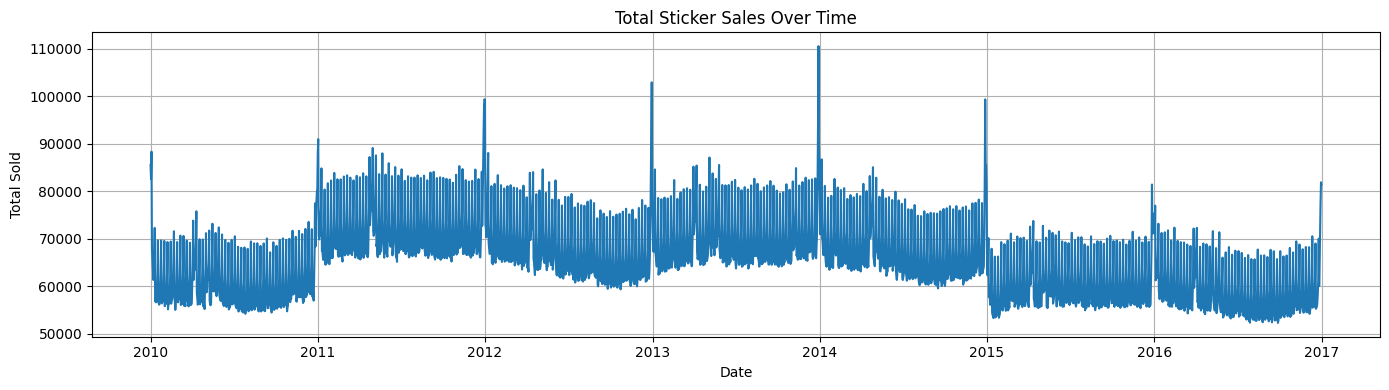

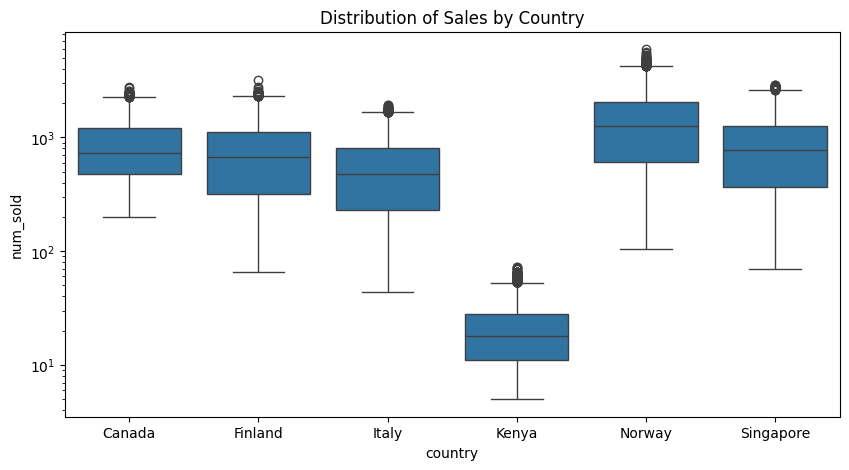

In [4]:
# Visual EDA – Time Series & Categorical Breakdown

import matplotlib.dates as mdates

# 1️⃣ Drop rows with missing num_sold (temporarily for EDA)
eda_df = train.dropna(subset=["num_sold"])

# 2️⃣ Daily Total Sales Over Time
daily_sales = eda_df.groupby("date")["num_sold"].sum()

plt.figure(figsize=(14, 4))
plt.plot(daily_sales.index, daily_sales.values, label="Total Daily Sales")
plt.title("Total Sticker Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3️⃣ Sales by Country
plt.figure(figsize=(10, 5))
sns.boxplot(data=eda_df, x="country", y="num_sold")
plt.title("Distribution of Sales by Country")
plt.yscale("log")  # Optional: log scale to reduce skew
plt.show()


### Graph Comment
**1️⃣ Total Sticker Sales Over Time**<br>
Seasonal fluctuations are quite pronounced. Sharp sales increases are seen late each year (probably around December)—most likely a New Year's or holiday season effect.

A regular weekly cycle is also noteworthy: high-low fluctuations suggest sales increase on specific days (likely weekends, etc.).

**2️⃣ Sales by Country (log-scale boxplot)**<br>
Sales volume is high in all countries except Kenya.

Kenya's sales figures are quite low, and the distribution is tight.

Norway has the highest average sales.

In [5]:
# Feature Engineering

# We will delete the missing num_sold data.
# We will extract time-based features from the date column (such as year, month, week, day, holiday effect).
# We will convert categorical variables with LabelEncoder or OneHotEncoder.

# 1️⃣ Drop missing target rows (we will not use them for training)
df = train.dropna(subset=["num_sold"]).copy()
df["num_sold"] = df["num_sold"].astype(int)

# 2️⃣ Convert date
df["date"] = pd.to_datetime(df["date"])

# 3️⃣ Extract date-based features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)

# 4️⃣ Is weekend or holiday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

# 5️⃣ Categorical encoding (Label Encoding for now)
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
le_store = LabelEncoder()
le_product = LabelEncoder()

df["country_enc"] = le_country.fit_transform(df["country"])
df["store_enc"] = le_store.fit_transform(df["store"])
df["product_enc"] = le_product.fit_transform(df["product"])


In [6]:
df.head()

,id,date,country,store,product,num_sold,year,month,day,weekday,weekofyear,is_weekend,country_enc,store_enc,product_enc
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973,2010,1,1,4,53,0,0,0,1
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906,2010,1,1,4,53,0,0,0,2
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423,2010,1,1,4,53,0,0,0,3
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491,2010,1,1,4,53,0,0,0,4
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300,2010,1,1,4,53,0,0,2,0


In [7]:
# Prepare Test Set for Prediction

# We'll apply the same feature engineering processes to the test.csv file.
# Model training (starting with LightGBM as an firstly)
# We'll save the predictions in sample_submission.csv format, ready for upload to Kaggle.

# 1️⃣ Load test.csv and sample_submission.csv again (if needed)
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

# 2️⃣ Feature engineering for test set
test["date"] = pd.to_datetime(test["date"])
test["year"] = test["date"].dt.year
test["month"] = test["date"].dt.month
test["day"] = test["date"].dt.day
test["weekday"] = test["date"].dt.weekday
test["weekofyear"] = test["date"].dt.isocalendar().week.astype(int)
test["is_weekend"] = test["weekday"].isin([5, 6]).astype(int)

# 3️⃣ Encode categorical features using same encoders
test["country_enc"] = le_country.transform(test["country"])
test["store_enc"] = le_store.transform(test["store"])
test["product_enc"] = le_product.transform(test["product"])


In [14]:
# Model Training & Prediction with LightGBM

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping
import numpy as np

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error

# 1️⃣ Define the model
model = LGBMRegressor(
    objective="regression",
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=1000,
    random_state=42
)

# 2️⃣ Train the model with proper callbacks (no verbose param)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)])

# 3️⃣ Evaluate performance
y_pred_val = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
print("✅ Validation RMSE:", rmse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 9
[LightGBM] [Info] Start training from score 751.724474
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 5082.54
[200]	valid_0's l2: 4039.42
[300]	valid_0's l2: 3683.23
[400]	valid_0's l2: 3487.14
[500]	valid_0's l2: 3358.61
[600]	valid_0's l2: 3262.88
[700]	valid_0's l2: 3193.93
[800]	valid_0's l2: 3151.68
[900]	valid_0's l2: 3115.37
[1000]	valid_0's l2: 3086.75
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 3086.75
✅ Validation RMSE: 55.558517051836525


### Enhanced Feature Engineering

**Our goal:**
- Make the model more suitable for RMSLE metrics by applying a log1p transformation.
- Generate sinusoidal (seasonal) features based on day_of_year.
- Adding a simple is_holiday feature for holiday effects (e.g., New Year's Eve).

In [15]:
import numpy as np

# 1️⃣ Log transformation for target
df["num_sold_log"] = np.log1p(df["num_sold"])

# 2️⃣ Day of year & sinusoidal features
df["day_of_year"] = df["date"].dt.dayofyear
df["sin_doy"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_doy"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

# 3️⃣ Add a dummy holiday feature (e.g., Jan 1)
df["is_holiday"] = ((df["month"] == 1) & (df["day"] == 1)).astype(int)


In [16]:
# Apply to test set
test["day_of_year"] = test["date"].dt.dayofyear
test["sin_doy"] = np.sin(2 * np.pi * test["day_of_year"] / 365)
test["cos_doy"] = np.cos(2 * np.pi * test["day_of_year"] / 365)
test["is_holiday"] = ((test["month"] == 1) & (test["day"] == 1)).astype(int)


In [17]:
# Updated features
features_v2 = ["year", "month", "day", "weekday", "weekofyear", "is_weekend",
               "country_enc", "store_enc", "product_enc",
               "sin_doy", "cos_doy", "is_holiday"]


In [19]:
# Model Training (v2) – log1p Target + Sin/Cos + Holiday

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1️⃣ Prepare features and new target
X = df[features_v2]
y = df["num_sold_log"]  # log1p transformed target

# 2️⃣ Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ Define model
model_v2 = LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    random_state=42
)

# 4️⃣ Train the model
model_v2.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             callbacks=[early_stopping(50), log_evaluation(100)])

# 5️⃣ Predict and evaluate
y_pred_val_log = model_v2.predict(X_val)
y_pred_val = np.expm1(y_pred_val_log)  # inverse transform
y_val_actual = np.expm1(y_val)

# Correct RMSE computation (without squared=False)
mse_v2 = mean_squared_error(y_val_actual, y_pred_val)
rmse_v2 = np.sqrt(mse_v2)
print("✅ Improved Validation RMSE:", rmse_v2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 12
[LightGBM] [Info] Start training from score 5.936249
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.00818042
[200]	valid_0's l2: 0.00403477
[300]	valid_0's l2: 0.00347851
[400]	valid_0's l2: 0.00325737
[500]	valid_0's l2: 0.00312461
[600]	valid_0's l2: 0.00303545
[700]	valid_0's l2: 0.00297476
[800]	valid_0's l2: 0.00292984
[900]	valid_0's l2: 0.00289497
[1000]	valid_0's l2: 0.00286592
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00286592
✅ Improved Validation RMSE: 55.42703199196648


In [20]:
# Predict and Submission

# 1️⃣ Prepare test features
X_test_v2 = test[features_v2]

# 2️⃣ Predict (log domain)
test_preds_log = model_v2.predict(X_test_v2)

# 3️⃣ Inverse log1p
test_preds = np.expm1(test_preds_log)
test_preds = np.round(test_preds).astype(int)

# 4️⃣ Create final submission
submission["num_sold"] = test_preds
submission.to_csv("submission_v2.csv", index=False)

print("✅ submission_v2.csv created with improved model!")
submission.head()


✅ submission_v2.csv created with improved model!


,id,num_sold
0,230130,136
1,230131,839
2,230132,756
3,230133,388
4,230134,459


### Enhanced Strategy Plan: Stacking + Pseudo-Labeling
**Target:**
- Stacking: Combining multiple models to obtain more robust predictions.
- Pseudo-labeling: Adding additional "half-labeled" data to the training data by using predictions from the test set.


In [21]:
# Training Baseline Models

from sklearn.linear_model import Ridge
import xgboost as xgb

# Common train/val split
X = df[features_v2]
y_log = df["num_sold_log"]
X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 1️⃣ LightGBM
lgb_model = LGBMRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)
lgb_model.fit(X_train, y_train)
val_pred_lgb = lgb_model.predict(X_val)
test_pred_lgb = lgb_model.predict(test[features_v2])

# 2️⃣ XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)
xgb_model.fit(X_train, y_train)
val_pred_xgb = xgb_model.predict(X_val)
test_pred_xgb = xgb_model.predict(test[features_v2])

# 3️⃣ Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
val_pred_ridge = ridge_model.predict(X_val)
test_pred_ridge = ridge_model.predict(test[features_v2])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 12
[LightGBM] [Info] Start training from score 5.936249


In [22]:
# 1️⃣ Stack Validation Predictions
stacked_val_preds = np.vstack([
    val_pred_lgb,
    val_pred_xgb,
    val_pred_ridge
]).T

# 2️⃣ Meta Model
meta_model = Ridge()
meta_model.fit(stacked_val_preds, y_val)

# 3️⃣ Stack Test Predictions
stacked_test_preds = np.vstack([
    test_pred_lgb,
    test_pred_xgb,
    test_pred_ridge
]).T

# 4️⃣ Final Test Prediction
final_test_log_preds = meta_model.predict(stacked_test_preds)
final_test_preds = np.expm1(final_test_log_preds).astype(int)

# 5️⃣ Submission
submission["num_sold"] = final_test_preds
submission.to_csv("submission_stacked.csv", index=False)
print("✅ submission_stacked.csv created (Stacked Model)")


✅ submission_stacked.csv created (Stacked Model)


In [23]:
# Pseudo-Labeling (Incorporating Future Data into Education)

# 1️⃣ Create label on Log domain'de pseudo 
test_pseudo = test.copy()
test_pseudo["num_sold_log"] = final_test_log_preds  # stacking output (log domain)

# 2️⃣ Merge with Training data
pseudo_df = pd.concat([df[features_v2 + ["num_sold_log"]], test_pseudo[features_v2 + ["num_sold_log"]]], axis=0)


In [24]:
# Final Model training

# 3️⃣ New X, y definite
X_full = pseudo_df[features_v2]
y_full = pseudo_df["num_sold_log"]

# 4️⃣ Final model (just start with LGBM)
final_model = LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    n_estimators=1000,
    random_state=42
)
final_model.fit(X_full, y_full)

# 5️⃣ Predict & Submission
test_preds_log_pseudo = final_model.predict(test[features_v2])
test_preds_pseudo = np.expm1(test_preds_log_pseudo).round().astype(int)

submission["num_sold"] = test_preds_pseudo
submission.to_csv("submission_pseudo.csv", index=False)

print("✅ submission_pseudo.csv created (with pseudo-labels)")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 319809, number of used features: 12
[LightGBM] [Info] Start training from score 5.894783
✅ submission_pseudo.csv created (with pseudo-labels)


In [25]:
# Ensemble + Pseudo-labeling

# Assign log domain test predictions as pseudo-label
test_pseudo = test.copy()
test_pseudo["num_sold_log"] = final_test_log_preds  # stacking'ten gelen log tahminler

# Merge Train data + pseudo-label
pseudo_df = pd.concat([
    df[features_v2 + ["num_sold_log"]],
    test_pseudo[features_v2 + ["num_sold_log"]]
], axis=0)

# Feature/target
X_pseudo = pseudo_df[features_v2]
y_pseudo = pseudo_df["num_sold_log"]


In [26]:
# Train All Models and Predict to Test

# 1️⃣ LightGBM
model_lgb = LGBMRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)
model_lgb.fit(X_pseudo, y_pseudo)
pred_lgb = model_lgb.predict(test[features_v2])

# 2️⃣ XGBoost
model_xgb = xgb.XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)
model_xgb.fit(X_pseudo, y_pseudo)
pred_xgb = model_xgb.predict(test[features_v2])

# 3️⃣ Ridge
model_ridge = Ridge()
model_ridge.fit(X_pseudo, y_pseudo)
pred_ridge = model_ridge.predict(test[features_v2])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 319809, number of used features: 12
[LightGBM] [Info] Start training from score 5.894783


In [27]:
# Ensemble Predict + Submission

# Ensemble (average)
final_log_preds_ensemble = (pred_lgb + pred_xgb + pred_ridge) / 3
final_preds_ensemble = np.expm1(final_log_preds_ensemble).round().astype(int)

# Submission
submission["num_sold"] = final_preds_ensemble
submission.to_csv("submission_ensemble_pseudo.csv", index=False)
print("✅ submission_ensemble_pseudo.csv created successfully!")


✅ submission_ensemble_pseudo.csv created successfully!


In [28]:
import pickle

# Save the model

with open("model_v2.pkl", "wb") as f:
    pickle.dump(model_v2, f)

print("✅ model_v2.pkl saved successfully.")


✅ model_v2.pkl saved successfully.
